In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
sns.set_style('darkgrid')

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-10-03 10:17:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-10-03 10:17:50 (41.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [7]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [8]:
# Walk through each directory
dataset = "../input/sea-animals-image-dataste"
walk_through_dir(dataset)

There are 23 directories and 0 images in '../input/sea-animals-image-dataste'.
There are 0 directories and 482 images in '../input/sea-animals-image-dataste/Penguin'.
There are 0 directories and 497 images in '../input/sea-animals-image-dataste/Clams'.
There are 0 directories and 499 images in '../input/sea-animals-image-dataste/Lobster'.
There are 0 directories and 500 images in '../input/sea-animals-image-dataste/Otter'.
There are 0 directories and 497 images in '../input/sea-animals-image-dataste/Eel'.
There are 0 directories and 500 images in '../input/sea-animals-image-dataste/Corals'.
There are 0 directories and 531 images in '../input/sea-animals-image-dataste/Puffers'.
There are 0 directories and 483 images in '../input/sea-animals-image-dataste/Squid'.
There are 0 directories and 572 images in '../input/sea-animals-image-dataste/Whale'.
There are 0 directories and 579 images in '../input/sea-animals-image-dataste/Sea Urchins'.
There are 0 directories and 499 images in '../inpu

In [10]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [11]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("../input/sea-animals-image-dataste").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

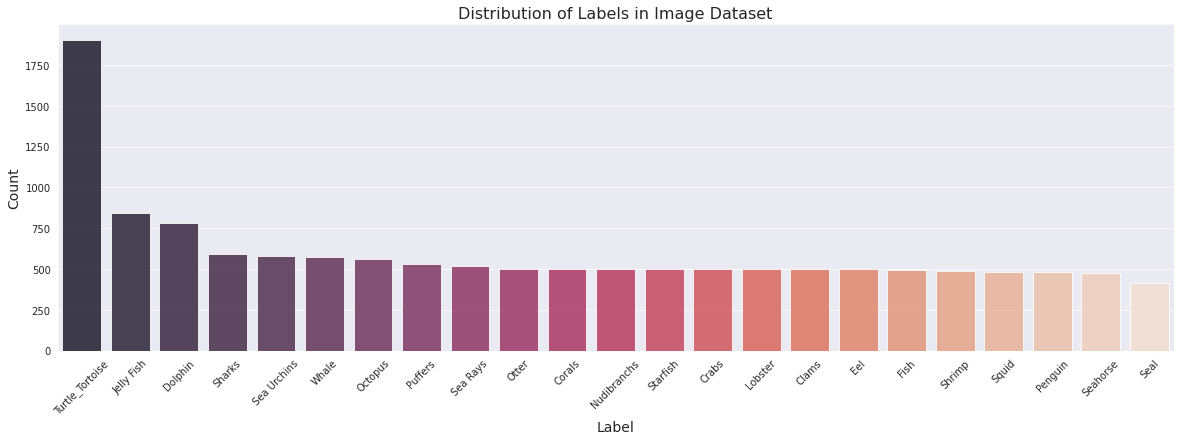

In [12]:
label_counts = image_df['Label'].value_counts()

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45) 
plt.show()


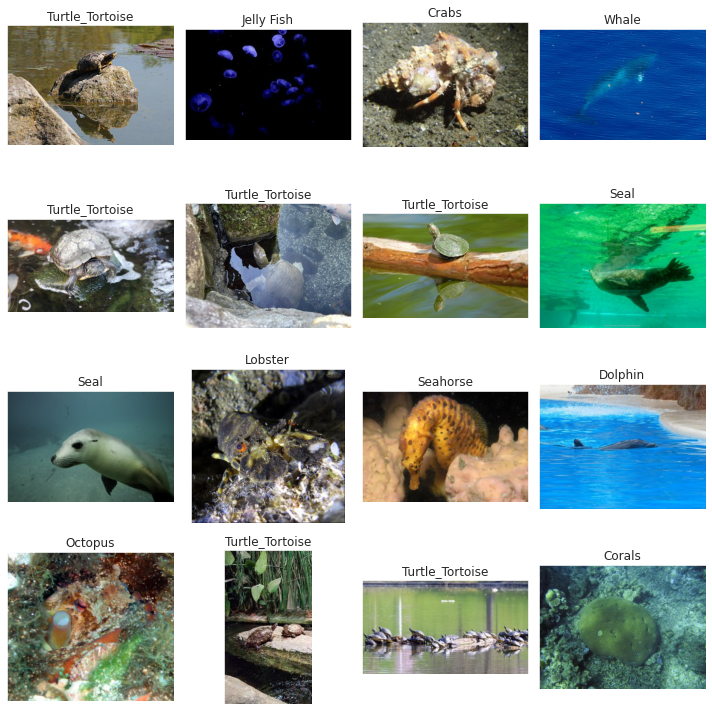

In [13]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [14]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

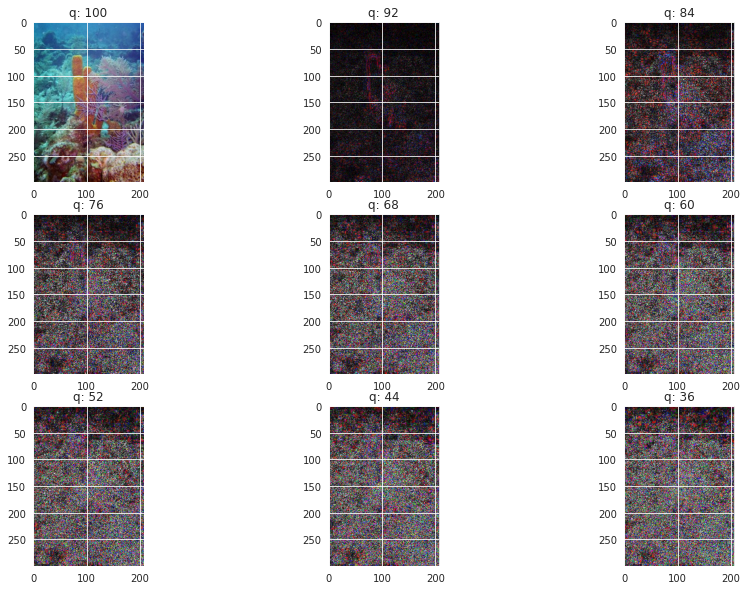

In [15]:
# View random sample from the dataset
p = random_sample('../input/sea-animals-image-dataste/Corals')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [16]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [17]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [19]:
class_labels = list(test_images.class_indices.keys())
print(class_labels)

['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']


In [20]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define input size (128x128) and 3 channels (RGB)
input_shape = (128, 128, 3)

# Load the pretrained MobileNetV2 model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,  # Exclude the top classification layers
    weights='imagenet',  # Use ImageNet weights
    pooling='max'        # Global max pooling
)

# Make the pretrained model non-trainable
pretrained_model.trainable = False


num_classes = 23  # Update this to the actual number of classes

# Build your model
inputs = layers.Input(shape=input_shape)
x = pretrained_model(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)  # Use softmax for multi-class classification

model = models.Model(inputs, outputs)

# Compile the model for multi-class classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Set up ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255,         # Rescale pixel values (0-255 to 0-1)
    rotation_range=20,       # Random rotations
    width_shift_range=0.2,   # Horizontal shifts
    height_shift_range=0.2,  # Vertical shifts
    shear_range=0.2,         # Shearing
    zoom_range=0.2,          # Zooming
    horizontal_flip=True,    # Horizontal flips
    fill_mode='nearest',     # Fill in missing pixels after transforms
    validation_split=0.2     # Split 20% of the data for validation
)

# Directory where the class folders are located
data_dir = '/kaggle/input/sea-animals-image-dataste/'

# Load training data (80% of the dataset)
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),  # Resize images to the input size of the model
    batch_size=32,           # Batch size
    class_mode='categorical',# Use 'categorical' for multi-class classification
    subset='training'        # Use training subset (80%)
)

# Load validation data (20% of the dataset)
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),  # Resize images to the input size of the model
    batch_size=32,           # Batch size
    class_mode='categorical',# Use 'categorical' for multi-class classification
    subset='validation'      # Use validation subset (20%)
)

# Start training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  # You can increase this for more training
)

# Save the trained model
model.save('trained_mobilenetv2_multiclass.h5')


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_16 (Dense)             (None, 128)               163968    
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 23)                2967      
Total params: 2,424,919
Trainable params: 166,935
Non-trainable params: 2,257,984
_________________________________________________________________
Found 10979 images belonging to 23 classes.
Found 2732 images belonging to 23 classes.
Epoch 1/10
343/343 [==

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


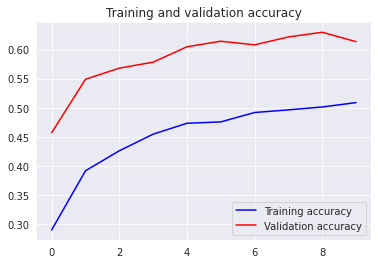

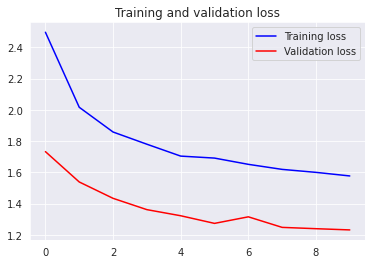

In [30]:


accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()



In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Enable memory growth for the GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


input_shape = (128, 128, 3)

# Load the pretrained VGG16 model
pretrained_model = tf.keras.applications.VGG16(
    input_shape=input_shape,
    include_top=False,  # Exclude the top classification layers
    weights='imagenet',  # Use ImageNet weights
    pooling='max'        # Global max pooling
)

# Make the pretrained model non-trainable
pretrained_model.trainable = False

# Number of classes (classes for sea animals)
num_classes = 23 # Adjust this to match the number of classes in your dataset

# Build your model
inputs = layers.Input(shape=input_shape)
x = pretrained_model(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)  # Softmax for multi-class classification

model = models.Model(inputs, outputs)

# Compile the model for multi-class classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


# Directory where the class folders are located
data_dir = '/kaggle/input/sea-animals-image-dataste/'


# Start training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  # You can increase this for more training
)

# Save the trained model
model.save('trained_vgg16_128x128_multiclass.h5')


Physical devices cannot be modified after being initialized
58900480/58889256 [==============================] - 0s 0us/step
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_18 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 23)                2967      
Total params: 14,783,319
Trainable params: 68,631
Non-trainable params: 14,714,688
_________________________________________________

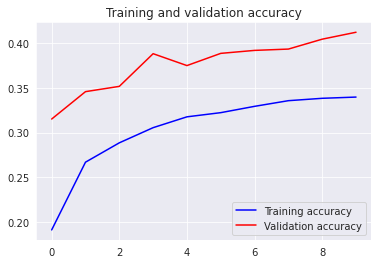

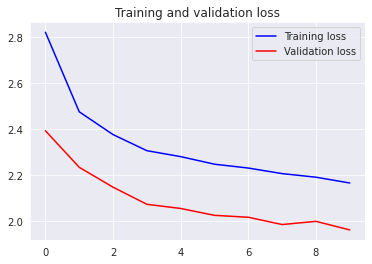

In [33]:


accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()



In [34]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

258088960/258076736 [==============================] - 1s 0us/step


In [35]:
# Create checkpoint callback
checkpoint_path = "animals_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [36]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [1]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(23, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "animal_classification"),
        checkpoint_callback,
    ]
)




Saving TensorBoard log files to: training_logs/animal_classification/20230605-150035

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)

Epoch 1/100
275/275 [==============================] - 110s 313ms/step - loss: 3.9292 - accuracy: 0.0752 - val_loss: 2.7560 - val_accuracy: 0.2745
Epoch 2/100
275/275 [==============================] - 79s 286ms/step - loss: 3.0011 - accuracy: 0.1322 - val_loss: 2.6268 - val_accuracy: 0.3342
Epoch 3/100
275/275 [==============================] - 79s 286ms/step - loss: 2.8353 - accuracy: 0.1814 - val_loss: 2.4497 - val_accuracy: 0.3949
Epoch 4/100
275/275 [==============================] - 79s 286ms/step - loss: 2.6943 - accuracy: 0.2223 - val_loss: 2.2833 - val_accuracy: 0.4337
Epoch 5/100
275/275 [==============================] - 

In [ ]:
model.save_weights('animals_eff.h5')

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

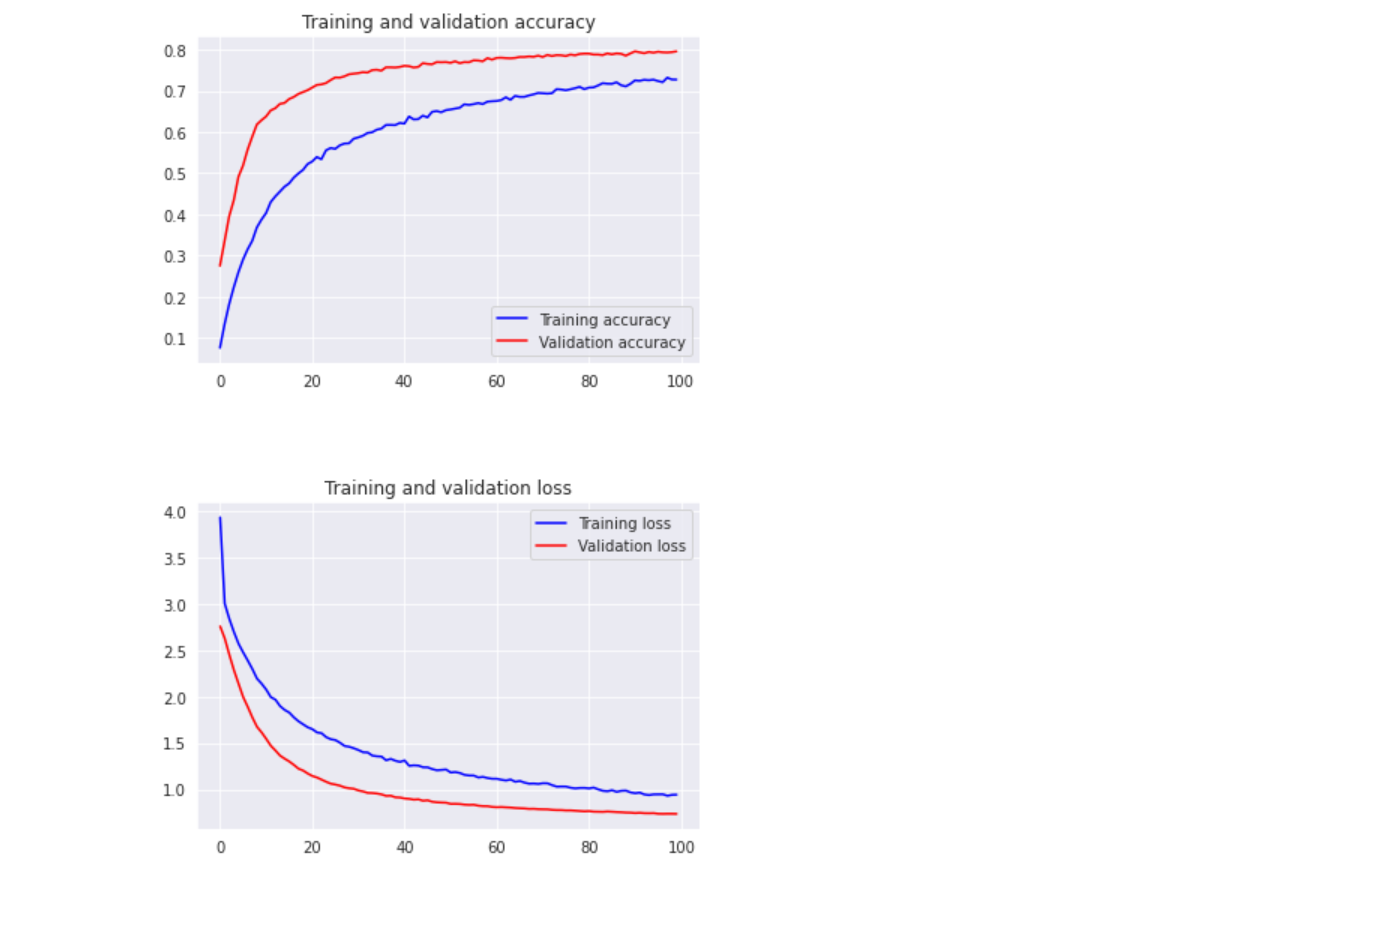